In [34]:
import pandas as pd
from pymatgen.core import Structure
from typing import Optional
import os
import sys
import e3nn_jax as e3nn
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pickle
from tqdm import tqdm

# Add src directory to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_dir = os.path.join(project_root, 'src')
sys.path.append(src_dir)

from utils.plotters import visualize_geometry, colorplot, visualize_signal, compare_geometries
from utils.geometries import trigonal_plane, tetrahedron, octahedron, icosahedron, dodecahedron, single_neighbor, linear, angular, see_saw
from utils.alignment import sample_uniform_quaternion, align_signals, find_best_random_quaternion, rotate_points_quaternion, stack_points, point_distance, spherical_harmonic_distance, stack_points, choose_best_quaternion, evenly_distributed_quaternions, quaternion_rotation_distance, spherical_grid_distance
import spectra
from spectra import sum_of_diracs, powerspectrum, bispectrum, trispectrum, invert, reconstruct_geometry

In [2]:
df = pd.read_csv('test.csv')
df.head()

,Unnamed: 0,material_id,formation_energy_per_atom,band_gap,pretty_formula,e_above_hull,elements,cif,spacegroup.number
0,6000,mp-10009,-0.575092,0.898,GaTe,0.000000,"['Ga', 'Te']",# generated using pymatgen\ndata_GaTe\n_symmet...,194
1,37702,mp-1218989,-0.942488,0.000,SmThCN,0.044109,"['C', 'N', 'Sm', 'Th']",# generated using pymatgen\ndata_SmThCN\n_symm...,160
2,42245,mp-1225695,0.064863,0.000,CuNi,0.064863,"['Cu', 'Ni']",# generated using pymatgen\ndata_CuNi\n_symmet...,65
3,780,mp-1220884,-1.456116,0.000,NaTiVS4,0.000000,"['Na', 'S', 'Ti', 'V']",# generated using pymatgen\ndata_NaTiVS4\n_sym...,8
4,35749,mp-1224266,0.024139,0.000,Ho3TmMn8,0.036496,"['Ho', 'Mn', 'Tm']",# generated using pymatgen\ndata_Ho3TmMn8\n_sy...,8


In [3]:
def load_cif_string(cif_string: str) -> Structure:
    try:
        # Load the structure from the CIF string
        structure = Structure.from_str(cif_string, fmt="cif")
        return structure
    except Exception as e:
        raise ValueError(f"Failed to parse CIF string: {str(e)}")

In [7]:
bispectrum_lmax4 = spectra.Spectra(lmax=4, order=2)
bispectrum_lmax5 = spectra.Spectra(lmax=5, order=2)

bispectra_lmax4 = []
bispectra_lmax5 = []

num_neighbors = []

for index, row in tqdm(df.iterrows()):

    if len(bispectra_lmax4) > 10000:
        break

    cif = row['cif']
    structure = load_cif_string(cif)
    bispectrum_lmax4.load_structure(structure)
    bispectra_lmax4.extend(bispectrum_lmax4.compute_structure_spectra().values())
    # bispectrum_lmax5.load_structure(structure)
    # bispectra_lmax5.extend(bispectrum_lmax5.compute_structure_spectra().values())
    num_neighbors.extend(bispectrum_lmax4.compute_structure_num_neighbors())

0it [00:00, ?it/s]

/Users/tphung/MIT Dropbox/Tuong Phung/repos/pyspectra/.venv/lib/python3.10/site-packages/pymatgen/core/structure.py:3100: UserWarning: Issues encountered while parsing CIF: 16 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  struct = parser.parse_structures(primitive=primitive)[0]
/Users/tphung/MIT Dropbox/Tuong Phung/repos/pyspectra/src/spectra.py:439: DeprecationWarning: dict interface is deprecated. Use attribute interface instead
  return set(symmetry_dataset['equivalent_atoms'])
13it [00:00, 17.97it/s]/Users/tphung/MIT Dropbox/Tuong Phung/repos/pyspectra/.venv/lib/python3.10/site-packages/pymatgen/core/structure.py:3100: UserWarning: Issues encountered while parsing CIF: 8 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  struct = parser.parse_structures(primitive=primitive)[0]
16it [00:00, 21.01it/s]/Users/tphung/MIT Dropbox/Tuong Phung/repos/pyspectra/.venv/lib/python3.10/site-packages/pymatgen/core/str

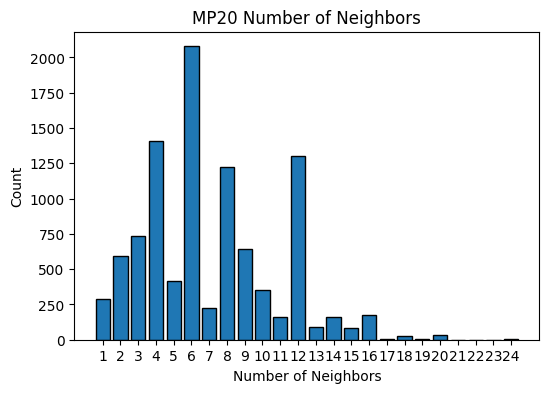

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Plot a histogram of num_neighbors with integer bins from 1 to the max
if len(num_neighbors) > 0:
    min_bin = 1
    max_bin = max(num_neighbors)
    bins = np.arange(min_bin, max_bin + 2) - 0.5  # bin edges so that each integer is centered
    plt.figure(figsize=(6,4))
    plt.hist(num_neighbors, bins=bins, edgecolor='black', rwidth=0.8)
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Count')
    plt.title('MP20 Number of Neighbors')
    plt.xticks(np.arange(min_bin, max_bin + 1))
    plt.show()

In [10]:
len(num_neighbors)

10001

In [11]:
len(bispectra_lmax4)

10001

Array([ 1.3605516e-02,  5.3008467e-17,  1.3173486e-02,  3.8967699e-02,
        9.9416738e-03,  1.8742563e-17, -4.9574267e-14,  4.3233195e-14,
       -4.5452844e-03,  7.9217162e-03,  2.8122514e-02, -5.6647952e-03,
        9.3464348e-03,  2.5977176e-03,  0.0000000e+00], dtype=float32)

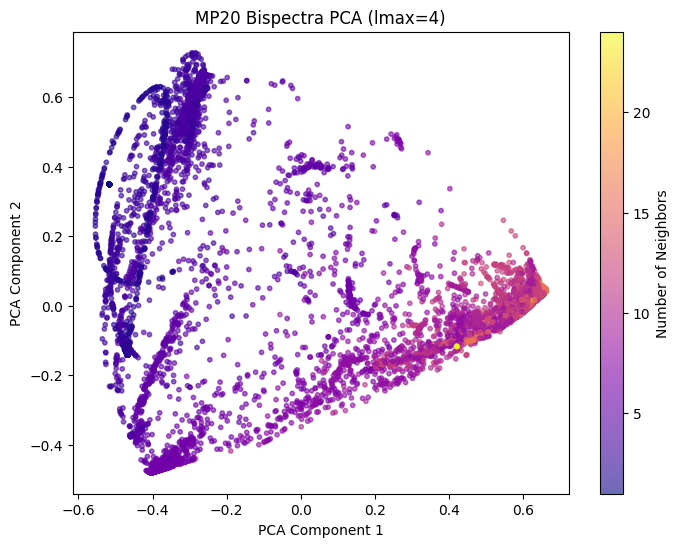

In [28]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Convert bispectra to a 2D numpy array and normalize each vector
X = np.array([np.ravel(b) for b in bispectra_lmax4])
# Normalize each vector to unit norm
norms = np.linalg.norm(X, axis=1, keepdims=True)
# Avoid division by zero
norms[norms == 0] = 1
X_normalized = X / norms

# Perform PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)

# Prepare color mapping based on num_neighbors
num_neighbors_arr = np.array(num_neighbors[:len(X_pca)])  # Ensure same length
cmap = plt.get_cmap('plasma')
norm = plt.Normalize(vmin=num_neighbors_arr.min(), vmax=num_neighbors_arr.max())
colors = cmap(norm(num_neighbors_arr))

# Plot the 2D PCA with color according to number of neighbors
plt.figure(figsize=(8,6))
sc = plt.scatter(X_pca[:,0], X_pca[:,1], c=num_neighbors_arr, cmap='plasma', alpha=0.6, s=10)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('MP20 Bispectra PCA (lmax=4)')
cbar = plt.colorbar(sc, label='Number of Neighbors')
plt.show()


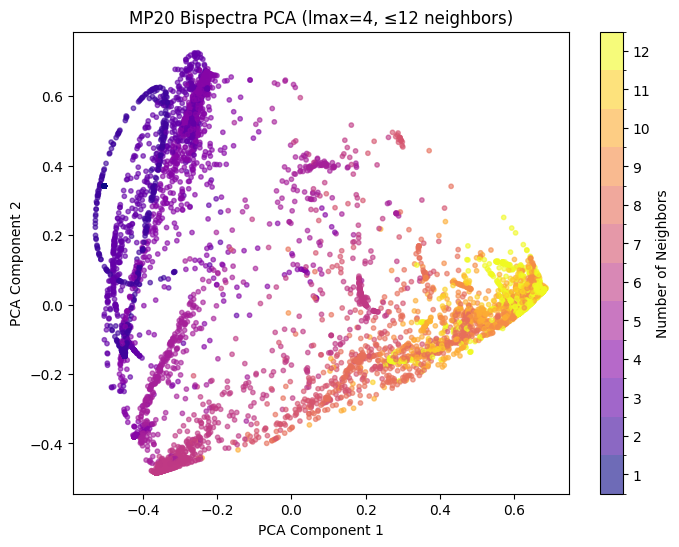

In [27]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import BoundaryNorm

# Convert bispectra to a 2D numpy array and normalize each vector
X = np.array([np.ravel(b) for b in bispectra_lmax4])
# Normalize each vector to unit norm
norms = np.linalg.norm(X, axis=1, keepdims=True)
# Avoid division by zero
norms[norms == 0] = 1
X_normalized = X / norms

# Prepare color mapping based on num_neighbors and filter for <=12 neighbors
num_neighbors_arr = np.array(num_neighbors[:len(X_normalized)])  # Ensure same length
mask = num_neighbors_arr <= 12
X_normalized_filtered = X_normalized[mask]
num_neighbors_filtered = num_neighbors_arr[mask]

# Perform PCA to reduce to 2 dimensions on filtered data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized_filtered)

# Discretize colorbar: bins for each integer number of neighbors
unique_neighbors = np.unique(num_neighbors_filtered)
bounds = np.arange(unique_neighbors.min(), unique_neighbors.max() + 2) - 0.5  # e.g. 3.5, 4.5, ..., 12.5
norm = BoundaryNorm(bounds, ncolors=plt.get_cmap('plasma').N)
cmap = plt.get_cmap('plasma')

# Plot the 2D PCA with color according to number of neighbors (discretized colorbar)
plt.figure(figsize=(8,6))
sc = plt.scatter(X_pca[:,0], X_pca[:,1], c=num_neighbors_filtered, cmap=cmap, norm=norm, alpha=0.6, s=10)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('MP20 Bispectra PCA (lmax=4, ≤12 neighbors)')
cbar = plt.colorbar(sc, boundaries=bounds, ticks=unique_neighbors)
cbar.set_label('Number of Neighbors')
plt.show()


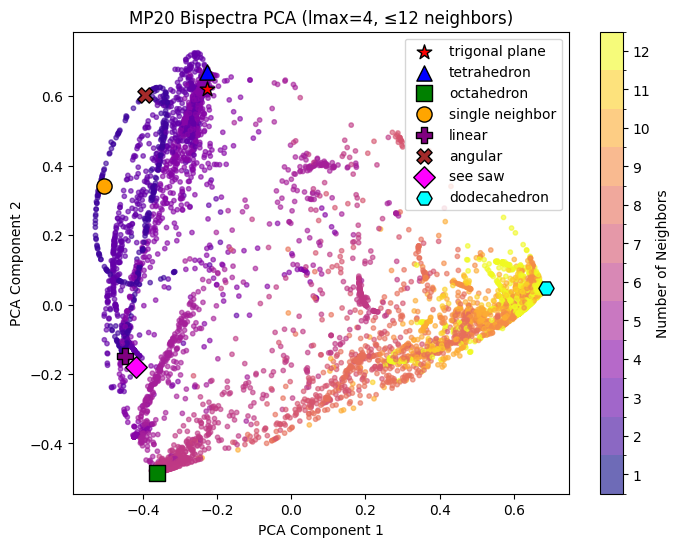

In [39]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import BoundaryNorm

# Compute and normalize the bispectra for all reference geometries
compute_bispectrum = lambda x: bispectrum(sum_of_diracs(x, lmax=4))

reference_geometries = {
    "trigonal_plane": trigonal_plane,
    "tetrahedron": tetrahedron,
    "octahedron": octahedron,
    "single_neighbor": single_neighbor,
    "linear": linear,
    "angular": angular,
    "see_saw": see_saw,
    "dodecahedron": dodecahedron,
}

reference_bispectra = {}
reference_bispectra_vecs = {}
for name, geom in reference_geometries.items():
    b = compute_bispectrum(geom)
    b_vec = np.ravel(b)
    norm = np.linalg.norm(b_vec)
    if norm == 0:
        norm = 1
    b_vec = b_vec / norm
    reference_bispectra[name] = b
    reference_bispectra_vecs[name] = b_vec

# Convert bispectra to a 2D numpy array and normalize each vector
X = np.array([np.ravel(b) for b in bispectra_lmax4])
# Normalize each vector to unit norm
norms = np.linalg.norm(X, axis=1, keepdims=True)
norms[norms == 0] = 1
X_normalized = X / norms

# Prepare color mapping based on num_neighbors and filter for <=12 neighbors
num_neighbors_arr = np.array(num_neighbors[:len(X_normalized)])  # Ensure same length
mask = num_neighbors_arr <= 12
X_normalized_filtered = X_normalized[mask]
num_neighbors_filtered = num_neighbors_arr[mask]

# Perform PCA to reduce to 2 dimensions on filtered data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized_filtered)

# Project the normalized reference bispectra into the same PCA space
reference_bispectra_pca = {}
for name, b_vec in reference_bispectra_vecs.items():
    reference_bispectra_pca[name] = pca.transform(b_vec.reshape(1, -1))[0]

# Discretize colorbar: bins for each integer number of neighbors
unique_neighbors = np.unique(num_neighbors_filtered)
bounds = np.arange(unique_neighbors.min(), unique_neighbors.max() + 2) - 0.5  # e.g. 3.5, 4.5, ..., 12.5
norm = BoundaryNorm(bounds, ncolors=plt.get_cmap('plasma').N)
cmap = plt.get_cmap('plasma')

# Plot the 2D PCA with color according to number of neighbors (discretized colorbar)
plt.figure(figsize=(8,6))
sc = plt.scatter(X_pca[:,0], X_pca[:,1], c=num_neighbors_filtered, cmap=cmap, norm=norm, alpha=0.6, s=10)

# Plot all reference geometries
markers = {
    "trigonal_plane": ("*", "red"),
    "tetrahedron": ("^", "blue"),
    "octahedron": ("s", "green"),
    "single_neighbor": ("o", "orange"),
    "linear": ("P", "purple"),
    "angular": ("X", "brown"),
    "see_saw": ("D", "magenta"),
    "dodecahedron": ("H", "cyan"),
}
for name, (marker, color) in markers.items():
    p = reference_bispectra_pca[name]
    plt.scatter(
        p[0], p[1],
        color=color, edgecolor='black', s=120, marker=marker, label=name.replace("_", " ")
    )

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('MP20 Bispectra PCA (lmax=4, ≤12 neighbors)')
cbar = plt.colorbar(sc, boundaries=bounds, ticks=unique_neighbors)
cbar.set_label('Number of Neighbors')
plt.legend()
plt.show()


In [20]:
bispectrum_lmax5 = spectra.Spectra(lmax=5, order=2)
bispectra_lmax5 = []
num_neighbors_lmax5 = []

for index, row in tqdm(df.iterrows()):

    if len(bispectra_lmax5) > 10000:
        break

    cif = row['cif']
    structure = load_cif_string(cif)
    bispectrum_lmax5.load_structure(structure)
    bispectra_lmax5.extend(bispectrum_lmax5.compute_structure_spectra().values())
    num_neighbors_lmax5.extend(bispectrum_lmax5.compute_structure_num_neighbors())

452it [00:25, 20.30it/s]/Users/tphung/MIT Dropbox/Tuong Phung/repos/pyspectra/.venv/lib/python3.10/site-packages/pymatgen/core/structure.py:3100: UserWarning: Issues encountered while parsing CIF: 6 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  struct = parser.parse_structures(primitive=primitive)[0]
506it [00:28, 24.41it/s]/Users/tphung/MIT Dropbox/Tuong Phung/repos/pyspectra/.venv/lib/python3.10/site-packages/pymatgen/core/structure.py:3100: UserWarning: Issues encountered while parsing CIF: 14 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  struct = parser.parse_structures(primitive=primitive)[0]
806it [00:43, 18.73it/s]/Users/tphung/MIT Dropbox/Tuong Phung/repos/pyspectra/.venv/lib/python3.10/site-packages/pymatgen/core/structure.py:3100: UserWarning: Issues encountered while parsing CIF: 24 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  struct = parser.parse_s

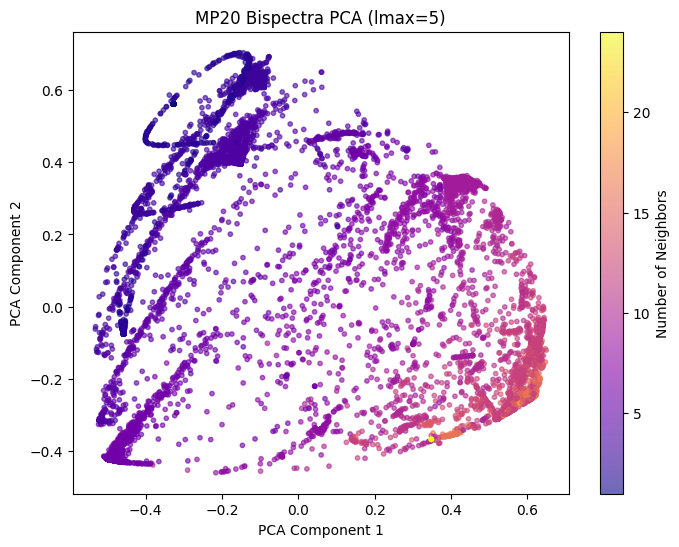

In [26]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Convert bispectra to a 2D numpy array and normalize each vector
X = np.array([np.ravel(b) for b in bispectra_lmax5])
# Normalize each vector to unit norm
norms = np.linalg.norm(X, axis=1, keepdims=True)
# Avoid division by zero
norms[norms == 0] = 1
X_normalized = X / norms

# Perform PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)

# Prepare color mapping based on num_neighbors
num_neighbors_arr = np.array(num_neighbors[:len(X_pca)])  # Ensure same length
cmap = plt.get_cmap('plasma')
norm = plt.Normalize(vmin=num_neighbors_arr.min(), vmax=num_neighbors_arr.max())
colors = cmap(norm(num_neighbors_arr))

# Plot the 2D PCA with color according to number of neighbors
plt.figure(figsize=(8,6))
sc = plt.scatter(X_pca[:,0], X_pca[:,1], c=num_neighbors_arr, cmap='plasma', alpha=0.6, s=10)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('MP20 Bispectra PCA (lmax=5)')
cbar = plt.colorbar(sc, label='Number of Neighbors')
plt.show()


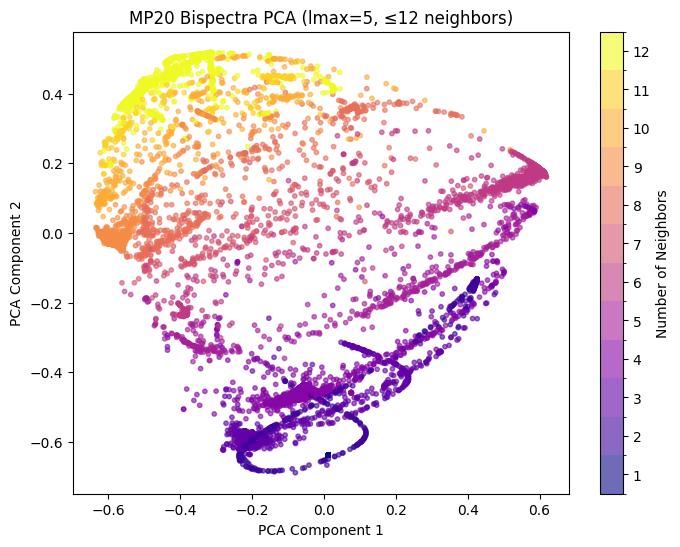

In [25]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import BoundaryNorm

# Convert bispectra to a 2D numpy array and normalize each vector
X = np.array([np.ravel(b) for b in bispectra_lmax5])
# Normalize each vector to unit norm
norms = np.linalg.norm(X, axis=1, keepdims=True)
# Avoid division by zero
norms[norms == 0] = 1
X_normalized = X / norms

# Prepare color mapping based on num_neighbors and filter for <=12 neighbors
num_neighbors_arr = np.array(num_neighbors[:len(X_normalized)])  # Ensure same length
mask = num_neighbors_arr <= 12
X_normalized_filtered = X_normalized[mask]
num_neighbors_filtered = num_neighbors_arr[mask]

# Perform PCA to reduce to 2 dimensions on filtered data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized_filtered)

# Discretize colorbar: bins for each integer number of neighbors
unique_neighbors = np.unique(num_neighbors_filtered)
bounds = np.arange(unique_neighbors.min(), unique_neighbors.max() + 2) - 0.5  # e.g. 3.5, 4.5, ..., 12.5
norm = BoundaryNorm(bounds, ncolors=plt.get_cmap('plasma').N)
cmap = plt.get_cmap('plasma')

# Plot the 2D PCA with color according to number of neighbors (discretized colorbar)
plt.figure(figsize=(8,6))
sc = plt.scatter(X_pca[:,0], X_pca[:,1], c=num_neighbors_filtered, cmap=cmap, norm=norm, alpha=0.6, s=10)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('MP20 Bispectra PCA (lmax=5, ≤12 neighbors)')
cbar = plt.colorbar(sc, boundaries=bounds, ticks=unique_neighbors)
cbar.set_label('Number of Neighbors')
plt.show()


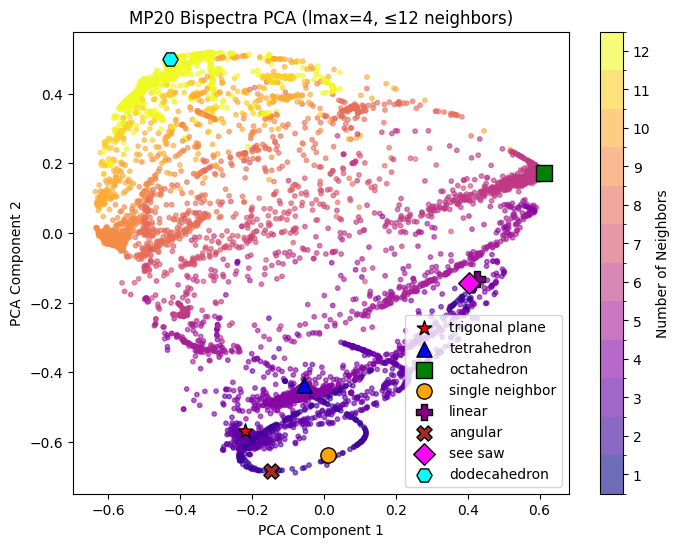

In [38]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import BoundaryNorm

# Compute and normalize the bispectra for all reference geometries
compute_bispectrum = lambda x: bispectrum(sum_of_diracs(x, lmax=5))

reference_geometries = {
    "trigonal_plane": trigonal_plane,
    "tetrahedron": tetrahedron,
    "octahedron": octahedron,
    "single_neighbor": single_neighbor,
    "linear": linear,
    "angular": angular,
    "see_saw": see_saw,
    "dodecahedron": dodecahedron,
}

reference_bispectra = {}
reference_bispectra_vecs = {}
for name, geom in reference_geometries.items():
    b = compute_bispectrum(geom)
    b_vec = np.ravel(b)
    norm = np.linalg.norm(b_vec)
    if norm == 0:
        norm = 1
    b_vec = b_vec / norm
    reference_bispectra[name] = b
    reference_bispectra_vecs[name] = b_vec

# Convert bispectra to a 2D numpy array and normalize each vector
X = np.array([np.ravel(b) for b in bispectra_lmax5])
# Normalize each vector to unit norm
norms = np.linalg.norm(X, axis=1, keepdims=True)
norms[norms == 0] = 1
X_normalized = X / norms

# Prepare color mapping based on num_neighbors and filter for <=12 neighbors
num_neighbors_arr = np.array(num_neighbors[:len(X_normalized)])  # Ensure same length
mask = num_neighbors_arr <= 12
X_normalized_filtered = X_normalized[mask]
num_neighbors_filtered = num_neighbors_arr[mask]

# Perform PCA to reduce to 2 dimensions on filtered data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized_filtered)

# Project the normalized reference bispectra into the same PCA space
reference_bispectra_pca = {}
for name, b_vec in reference_bispectra_vecs.items():
    reference_bispectra_pca[name] = pca.transform(b_vec.reshape(1, -1))[0]

# Discretize colorbar: bins for each integer number of neighbors
unique_neighbors = np.unique(num_neighbors_filtered)
bounds = np.arange(unique_neighbors.min(), unique_neighbors.max() + 2) - 0.5  # e.g. 3.5, 4.5, ..., 12.5
norm = BoundaryNorm(bounds, ncolors=plt.get_cmap('plasma').N)
cmap = plt.get_cmap('plasma')

# Plot the 2D PCA with color according to number of neighbors (discretized colorbar)
plt.figure(figsize=(8,6))
sc = plt.scatter(X_pca[:,0], X_pca[:,1], c=num_neighbors_filtered, cmap=cmap, norm=norm, alpha=0.6, s=10)

# Plot all reference geometries
markers = {
    "trigonal_plane": ("*", "red"),
    "tetrahedron": ("^", "blue"),
    "octahedron": ("s", "green"),
    "single_neighbor": ("o", "orange"),
    "linear": ("P", "purple"),
    "angular": ("X", "brown"),
    "see_saw": ("D", "magenta"),
    "dodecahedron": ("H", "cyan"),
}
for name, (marker, color) in markers.items():
    p = reference_bispectra_pca[name]
    plt.scatter(
        p[0], p[1],
        color=color, edgecolor='black', s=120, marker=marker, label=name.replace("_", " ")
    )

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('MP20 Bispectra PCA (lmax=4, ≤12 neighbors)')
cbar = plt.colorbar(sc, boundaries=bounds, ticks=unique_neighbors)
cbar.set_label('Number of Neighbors')
plt.legend()
plt.show()
